In [1]:
import os
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.applications import VGG16
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

In [8]:
config = {
    "dataset_path": "images/",
    "validation_ratio": 0.2,
    "image_size": (300, 300),
    "batch_size": 32,
    "mode": "retrain",
    "loss_function": "categorical_crossentropy",
    "optimizer": "adam",
    "epochs": 100,
    "dropout": 0.0,
    "lr": 0.001,
    "checkpoint_pattern": "checkpoint/cp-{epoch:03d}.ckpt",
    "checkpoint_dir": "checkpoint/",
    "saved_model": "checkpoint/cp-035.ckpt"
}

# train/test 데이터셋 나누기

In [44]:
def image_loader(directory,
                 validation_split, 
                 image_size, 
                 batch_size,
                 subset="all"):
    
    train_ds, valid_ds = None, None
    if "all" == subset:
        subset = "train/valid"
    
    if "train" in subset:
        train_ds = image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            validation_split=validation_split,
            subset="training",
            seed=123,
            image_size=image_size,
            batch_size=batch_size)
        
    if "valid" in subset:
        valid_ds = image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            validation_split=validation_split,
            subset="validation",
            seed=123,
            image_size=image_size,
            batch_size=batch_size)
    
    return train_ds, valid_ds


AUTOTUNE = tf.data.experimental.AUTOTUNE

normalize = layers.experimental.preprocessing.Rescaling(1./255)
flip_rotation = ks.models.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal"),
      layers.experimental.preprocessing.RandomRotation(0.2),
    ])

def crop_hue_brightness(image, label):
    image = tf.image.random_crop(image, size=(config['batch_size'], 300, 300, 3))
    image = tf.image.random_hue(image, max_delta=0.25)
    image = tf.image.random_brightness(image, max_delta=0.25)
    return image, label

def preprocess(ds, shuffle=False, augment=False):
    if augment:
        ds = ds.map(crop_hue_brightness, num_parallel_calls=AUTOTUNE)
        ds = ds.map(lambda x, y: (flip_rotation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    ds = ds.map(lambda x, y: (normalize(x), y), 
              num_parallel_calls=AUTOTUNE)

    #return ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [45]:
train_ds, valid_ds = image_loader(config['dataset_path'], 
                                  config['validation_ratio'], 
                                  config['image_size'], 
                                  config['batch_size'])

print(train_ds.class_names)

train_ds = preprocess(train_ds, shuffle=True, augment=True)
valid_ds = preprocess(valid_ds)

Found 45000 files belonging to 3 classes.
Using 36000 files for training.
Found 45000 files belonging to 3 classes.
Using 9000 files for validation.
['exterior', 'food', 'interior']


# 콜백 작성하기

In [46]:
class CustomCallback(ks.callbacks.Callback):

    def __init__(self):
        self.t_loss = {}
        self.t_acc = {}
        
        self.v_acc = []
        self.step = 0

    def on_epoch_end(self, epoch, logs):
        print('\n==========\n')
        print('Epoch {} result'.format(epoch))
        
        print('Training Loss:', logs['loss'])
        print('Traininig Accuracy:', logs['accuracy'])
        
        print('Validation Loss:', logs['val_loss'])
        print('Validation Accuracy:', logs['val_accuracy'])
        self.v_acc.append(logs['val_accuracy'])
        
    def on_train_batch_end(self, batch, logs=None):
        self.t_acc[self.step] = logs['accuracy']
        self.t_loss[self.step] = logs['loss']
        self.step += 1

    def on_train_end(self, logs):
        import matplotlib.pyplot as plt
        plt.plot(self.t_loss.keys(), self.t_loss.values())
        plt.xlabel('Training Steps')
        plt.ylabel('Training Loss')
        plt.show()

        self.t_loss = {}
        self.t_acc = {}

recorder = CustomCallback()
checkpoint_callback = ks.callbacks.ModelCheckpoint(
    filepath=config["checkpoint_pattern"], 
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

In [47]:
with tf.device('/GPU:1'):
    mode = config['mode']
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    vgg16.trainable = False
    
    classifier = ks.models.Sequential([
        layers.Flatten(),
        layers.Dropout(config['dropout']),
        layers.Dense(200, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    
    model = ks.models.Sequential([
        vgg16,
        classifier
    ])
    
        
    if mode=="retrain" or mode=="test":
        model.load_weights(config['saved_model'])
        
    model.compile(loss=config['loss_function'], 
                  optimizer=config['optimizer'],
                  metrics=['accuracy'])
    model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
sequential_18 (Sequential)   (None, 3)                 8295203   
Total params: 23,009,891
Trainable params: 8,295,203
Non-trainable params: 14,714,688
_________________________________________________________________


# 학습

Epoch 1/100
1125/1125 [==============================] - 285s 177ms/step - loss: 0.3161 - accuracy: 0.8791 - val_loss: 0.3506 - val_accuracy: 0.8629


Epoch 0 result
Training Loss: 0.3004838526248932
Traininig Accuracy: 0.8840277791023254
Validation Loss: 0.35063567757606506
Validation Accuracy: 0.8628888726234436

Epoch 00001: saving model to checkpoint/cp-001.ckpt
Epoch 2/100
1125/1125 [==============================] - 283s 176ms/step - loss: 0.2930 - accuracy: 0.8880 - val_loss: 0.3121 - val_accuracy: 0.8853


Epoch 1 result
Training Loss: 0.288135826587677
Traininig Accuracy: 0.8886389136314392
Validation Loss: 0.3121359050273895
Validation Accuracy: 0.8853333592414856

Epoch 00002: saving model to checkpoint/cp-002.ckpt
Epoch 3/100
1125/1125 [==============================] - 287s 176ms/step - loss: 0.2840 - accuracy: 0.8888 - val_loss: 0.3212 - val_accuracy: 0.8816


Epoch 2 result
Training Loss: 0.28511539101600647
Traininig Accuracy: 0.889472246170044
Validation Loss: 0.321203

Epoch 23/100
1125/1125 [==============================] - 280s 177ms/step - loss: 0.2580 - accuracy: 0.8993 - val_loss: 0.3001 - val_accuracy: 0.8913


Epoch 22 result
Training Loss: 0.26177603006362915
Traininig Accuracy: 0.8970833420753479
Validation Loss: 0.30011844635009766
Validation Accuracy: 0.8913333415985107

Epoch 00023: saving model to checkpoint/cp-023.ckpt
Epoch 24/100
1125/1125 [==============================] - 286s 176ms/step - loss: 0.2570 - accuracy: 0.9000 - val_loss: 0.3012 - val_accuracy: 0.8877


Epoch 23 result
Training Loss: 0.2612933814525604
Traininig Accuracy: 0.8976389169692993
Validation Loss: 0.30121591687202454
Validation Accuracy: 0.887666642665863

Epoch 00024: saving model to checkpoint/cp-024.ckpt
Epoch 25/100
1125/1125 [==============================] - 286s 177ms/step - loss: 0.2517 - accuracy: 0.8988 - val_loss: 0.3217 - val_accuracy: 0.8856


Epoch 24 result
Training Loss: 0.2551197111606598
Traininig Accuracy: 0.899138867855072
Validation Loss: 0

Epoch 45/100
1125/1125 [==============================] - 285s 176ms/step - loss: 0.2452 - accuracy: 0.9027 - val_loss: 0.3322 - val_accuracy: 0.8903


Epoch 44 result
Training Loss: 0.2455993890762329
Traininig Accuracy: 0.903249979019165
Validation Loss: 0.3321966230869293
Validation Accuracy: 0.890333354473114

Epoch 00045: saving model to checkpoint/cp-045.ckpt
Epoch 46/100
1125/1125 [==============================] - 281s 177ms/step - loss: 0.2449 - accuracy: 0.9023 - val_loss: 0.3073 - val_accuracy: 0.8912


Epoch 45 result
Training Loss: 0.2442735731601715
Traininig Accuracy: 0.902388870716095
Validation Loss: 0.3072737157344818
Validation Accuracy: 0.8912222385406494

Epoch 00046: saving model to checkpoint/cp-046.ckpt
Epoch 47/100
1125/1125 [==============================] - 288s 177ms/step - loss: 0.2427 - accuracy: 0.9030 - val_loss: 0.3208 - val_accuracy: 0.8872


Epoch 46 result
Training Loss: 0.24533593654632568
Traininig Accuracy: 0.9016666412353516
Validation Loss: 0.32

Epoch 67/100
1125/1125 [==============================] - 282s 177ms/step - loss: 0.2392 - accuracy: 0.9049 - val_loss: 0.3389 - val_accuracy: 0.8817


Epoch 66 result
Training Loss: 0.2372545301914215
Traininig Accuracy: 0.9055833220481873
Validation Loss: 0.3388795554637909
Validation Accuracy: 0.8816666603088379

Epoch 00067: saving model to checkpoint/cp-067.ckpt
Epoch 68/100
1125/1125 [==============================] - 286s 177ms/step - loss: 0.2430 - accuracy: 0.9017 - val_loss: 0.3403 - val_accuracy: 0.8843


Epoch 67 result
Training Loss: 0.23970548808574677
Traininig Accuracy: 0.9028888940811157
Validation Loss: 0.3403136730194092
Validation Accuracy: 0.8843333125114441

Epoch 00068: saving model to checkpoint/cp-068.ckpt
Epoch 69/100
1125/1125 [==============================] - 285s 176ms/step - loss: 0.2370 - accuracy: 0.9070 - val_loss: 0.3376 - val_accuracy: 0.8916


Epoch 68 result
Training Loss: 0.23533499240875244
Traininig Accuracy: 0.9056666493415833
Validation Loss: 

Epoch 89/100
1125/1125 [==============================] - 280s 177ms/step - loss: 0.2275 - accuracy: 0.9067 - val_loss: 0.3583 - val_accuracy: 0.8801


Epoch 88 result
Training Loss: 0.23081280291080475
Traininig Accuracy: 0.9058611392974854
Validation Loss: 0.3583366572856903
Validation Accuracy: 0.8801110982894897

Epoch 00089: saving model to checkpoint/cp-089.ckpt
Epoch 90/100
1125/1125 [==============================] - 285s 177ms/step - loss: 0.2320 - accuracy: 0.9053 - val_loss: 0.3568 - val_accuracy: 0.8706


Epoch 89 result
Training Loss: 0.22816137969493866
Traininig Accuracy: 0.9079999923706055
Validation Loss: 0.35682904720306396
Validation Accuracy: 0.870555579662323

Epoch 00090: saving model to checkpoint/cp-090.ckpt
Epoch 91/100
1125/1125 [==============================] - 279s 176ms/step - loss: 0.2261 - accuracy: 0.9056 - val_loss: 0.3340 - val_accuracy: 0.8902


Epoch 90 result
Training Loss: 0.22547924518585205
Traininig Accuracy: 0.9080555438995361
Validation Loss:

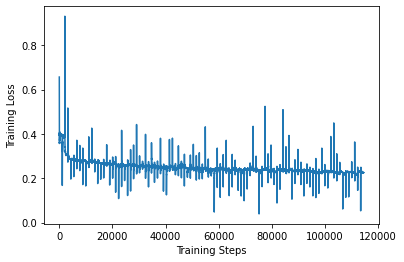

In [16]:
model.fit(train_ds, 
          validation_data=valid_ds, 
          epochs=config['epochs'],
          callbacks=[recorder, checkpoint_callback])

In [31]:
vacc = recorder.v_acc
vacc.index(max(vacc))

18

In [43]:
config = {
    "dataset_path": "images/",
    "validation_ratio": 0.2,
    "image_size": (300, 300),
    "batch_size": 32,
    "mode": "test",
    "loss_function": "categorical_crossentropy",
    "optimizer": "adam",
    "epochs": 1,
    "dropout": 0.0,
    "checkpoint_pattern": "checkpoint/cp-{epoch:03d}.ckpt",
    "checkpoint_dir": "checkpoint/",
    "saved_model": "checkpoint/cp-017.ckpt"
}

In [48]:
model.evaluate(valid_ds)

282/282 [==============================] - 37s 129ms/step - loss: 0.3051 - accuracy: 0.8922


[0.30003732442855835, 0.8913333415985107]